In [1]:
import os
import sys
import random
import datetime
import math
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd
import requests
import uuid
from datetime import datetime

In [2]:
MRCNN_DIR = os.path.abspath("../external/mask_rcnn")
sys.path.append(MRCNN_DIR)

In [3]:
COCO_DIR = os.path.abspath('../external/mask_rcnn/samples')
sys.path.append(COCO_DIR)


In [4]:
from mrcnn import visualize
from coco.coco import CocoConfig


Using TensorFlow backend.


In [5]:
from transform import ImageTransform
from preprocess import PreprocessImage
from postprocess import PostprocessImage

In [6]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [7]:
def get_config():
    class InferenceConfig(CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1

    config = InferenceConfig()
    return config


In [8]:
config = get_config()


In [9]:

transformClass = ImageTransform(config)
preprocessClass = PreprocessImage(config)
postprocessClass = PostprocessImage(config)

/anaconda2/envs/python36/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


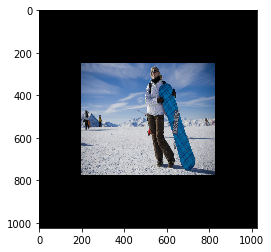

In [10]:
image_temp = skimage.io.imread('test_image.jpg')
image = transformClass.transform(image_temp, pad_width = 200)
plt.imshow(image)


In [33]:
image.dtype

dtype('uint8')

In [11]:
molded_image, image_meta, anchors, window =preprocessClass.preprocess_input(image)


In [43]:
molded_image.dtype

dtype('float64')

In [12]:
payload = {
"signature_name": "serving_default",
"instances": [
{'input_anchors': anchors.tolist(),
'input_image': molded_image.tolist(),
'input_image_meta': image_meta.tolist()}
]
}

In [34]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/coco_test:predict', data=json.dumps(payload), headers=headers)


In [35]:
json_response.status_code


200

In [36]:
json_response.keys()

AttributeError: 'Response' object has no attribute 'keys'

In [10]:

with open('test_image.jpg','rb') as textfile:
    bytestring = textfile.read()
payload_flask = {'image': bytestring}
json_response_flask = requests.post('http://localhost:5000/predict', files = payload_flask)


In [11]:
json_response_flask.status_code


500

In [15]:
# json_response.text


In [37]:
text = json_response.json()

In [38]:
text.keys()

dict_keys(['predictions'])

In [17]:
mrcnn_detection = np.array(text['predictions'][0]['mrcnn_detection/Reshape_1']).reshape(-1, *(1, 100, 6))
mrcnn_mask = np.array(text['predictions'][0]['mrcnn_mask/Reshape_1']).reshape(-1, *(1, 100, 28, 28, 81))

In [18]:
final_rois, final_class_ids, final_scores, final_masks = \
    postprocessClass.unmold_detections(
        mrcnn_detection,
        mrcnn_mask,
        image.shape,
        molded_image.shape,
        window
    )

In [19]:
final_class_ids


array([ 1,  1,  1,  1, 32], dtype=int32)

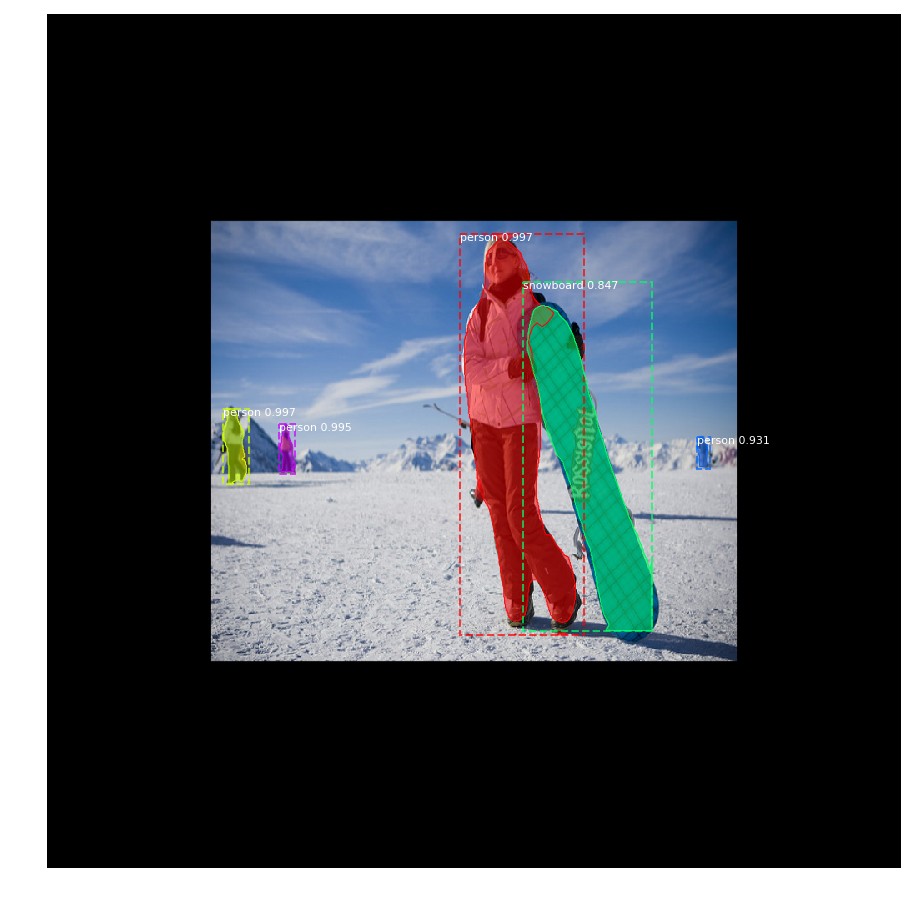

In [20]:
random_id = str(uuid.uuid4())
mask_fn = "mask-{}.png".format(random_id)
save_path = os.path.join("media", mask_fn)

visualize.display_instances(
    image,
    final_rois,
    final_masks,
    final_class_ids,
    class_names,
    final_scores
)

In [124]:
time_start = datetime.utcnow()
repeat = 10
for i in range(repeat):
    prediction = requests.post('http://localhost:8501/v1/models/coco_test:predict', data=json.dumps(payload), headers=headers)
    print(i)
    print(prediction.status_code)
time_end = datetime.utcnow()
time_elapsed_sec = (time_end - time_start).total_seconds()

print('Total elapsed time: {} seconds'.format(time_elapsed_sec))
print('Average latency per batch: {} seconds'.format(time_elapsed_sec/repeat))

0
200
1
200
2
200
3
200
4
200
5
200
6
200
7
200
8
200
9
200
Total elapsed time: 217.666502 seconds
Average latency per batch: 21.7666502 seconds


In [126]:
with open('payload.pkl', 'wb') as fid:
    pickle.dump(payload, fid)